This script was used to impute missing measurements due to analytical issues for the manuscript listed in the README. This script iteratively fits KNN models to artifical missing data (30%) and computes the distance between predicted and true values for 50 iterations. The outputs are plotted in `02.3 objectively_determine_k_plot.ipynb`.

The data going in to this script has duplicate samplenames removed and removes outliers that are more than 8 standard deviations away (see `02.1. filter_for_KNN.ipynb`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [2]:
# populate dictionary
store_estimations = {}
for k in range(2,101,2):
    key = f'k{k}'
    store_estimations[key] = []

In [3]:
%%time
mses_per_k = {}
# 50 reps of each k
for i in range(50):
    # STEP 1
    # Starting with the original dataset, remove all samples with NA values.
    vif_original = pd.read_csv("../df/vitis_ionomics_data_noOutlier.csv")
    vif_original = vif_original.dropna(axis='index')
    # we reset the index so it goes from 0 to 5941, step of 1.
    vif_original = vif_original.reset_index(drop=True)
    list_of_ions = ['B11', 'Na23', 'Mg26', 'Al27', 'P31', 'S34',
           'K39', 'Ca44', 'Fe54', 'Mn55', 'Co59', 'Ni60', 'Cu63', 'Zn66', 'As75',
           'Se78', 'Rb85', 'Sr88', 'Mo98', 'Cd111']
    # scale the data
    scaler = StandardScaler()
    vif_original[list_of_ions] = pd.DataFrame(scaler.fit(vif_original[list_of_ions]).transform(vif_original[list_of_ions]))

    # STEP 2
    # Randomly choose 30% of remaining samples
    ten_percent = math.floor(.3 * vif_original.shape[0])
    random_samples = sorted(set(random.sample(range(0,vif_original.shape[0]), k=ten_percent)))

    # STEP 3
    # Randomly introduce NAs into those samples. Store the true values.
    store_true = []
    for sample in random_samples:
        ion_to_null = random.choice(list_of_ions)
        true_val = vif_original.at[sample,ion_to_null]
        store_true.append([sample, ion_to_null, true_val])
        vif_original.at[sample,ion_to_null] = np.NaN
        
    # STEP 4
    # Impute over values of k. (2 to 100 by step size of 2)
    samplenames = vif_original.samplename
    for k in range(2,101,2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = pd.DataFrame(imputer.fit_transform(vif_original[list_of_ions]))
        imputed.columns = list_of_ions
        imputed['samplename'] = samplenames
        
        store_predicted = []
        for value in store_true:
            pred_val = imputed.at[value[0],value[1]]
            store_predicted.append([value[0], value[1], pred_val])
    
        # STEP 5
        # Calculate mean squared error
        se = 0
        for i in range(ten_percent):
            #print(f'({store_true[i][2]} - {store_predicted[i][2]})^2 = {(store_true[i][2] - store_predicted[i][2]) ** 2}')
            se += (store_true[i][2] - store_predicted[i][2]) ** 2
        mse = se / ten_percent
        access_key = f'k{k}'
        store_estimations[access_key].append(mse)

CPU times: user 1h 29min, sys: 55min 10s, total: 2h 24min 11s
Wall time: 38min 9s


In [4]:
averages = []
ks = []
for k in range(2,101,2):
    key = f'k{k}'
    average = sum(store_estimations[key]) / len(store_estimations[key])
    averages.append(average)
    ks.append(k)

Text(0.5, 1.0, 'optimal value for k')

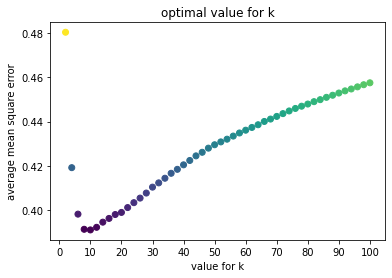

In [5]:
plt.scatter(ks, averages, marker='o', c=averages, cmap='viridis')
plt.xlabel('value for k')
plt.xticks(np.arange(0, 101, 10))
plt.ylabel('average mean square error')
plt.title('optimal value for k')

In [6]:
len(averages)

50

In [7]:
mse = pd.DataFrame(store_estimations)
mse.to_csv('objectively_determine_k_50reps_30percent.csv', index=False)